## LSTM for lag
Copied from https://cmsdk.com/python/lstm--learn-a-simple-lag-in-the-data.html

In [1]:
# import os
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
import keras
def strided_app(a, L, S ):  #To get X in the right format expected by Keras
    nrows = ((a.size-L)//S)+1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a, shape=(nrows,L), strides=(S*n,n))

import utils
import utils2

Using TensorFlow backend.


model (99998, 3) (99998, 1)


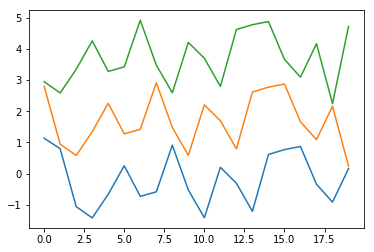

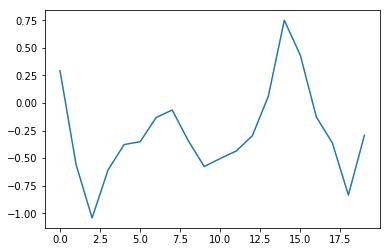

calib (99989, 10, 3) (99989, 1)


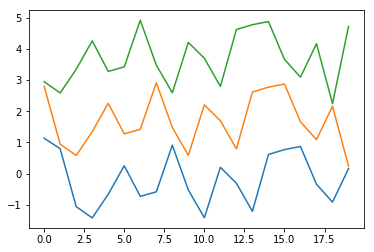

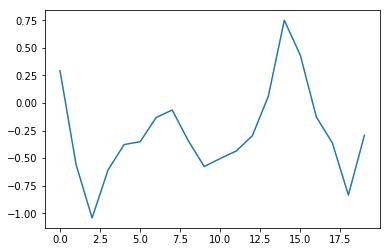

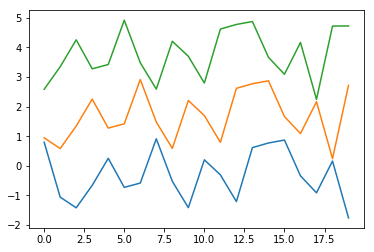

In [2]:
nb_samples = 100000
X = np.random.randn(nb_samples)
# generate data with 3-lag correlation: X(t-1), X(t), and X(t+1)
timesteps = 3
#Beta = np.zeros(timesteps)
#Beta[1] = 1
# something a bit more interesting: 3-pt moving average
Beta=[1/3,1/3,1/3]

X_model = strided_app(X, timesteps, 1)
Y_model = np.dot(X_model, Beta)
Y_model = Y_model.reshape(Y_model.shape[0],1)
print('model', X_model.shape, Y_model.shape)
utils.myPlot(X_model[:20],2)
utils.myPlot(Y_model[:20]) # should match with middle feature in X_model

# This seems to be just a copy of X_model
#X_calib = strided_app(X, timesteps, 1)
#Y_calib = Y_model[:X_calib.shape[0]]
#print('calib', X_calib.shape, Y_calib.shape)
#utils.myPlot(X_calib[:20],2)

# no need to add this extra dimension
# The OP probably thought s/he needed it because s/he was missing the re-striding (check below)
# X_calib = X_calib.reshape(X_calib.shape[0], timesteps, 1)

# The first striding above was done in order to generate the input data with a built-in lag relationship
# Now need to stride again because we need to pretend that we do not know that the input has this correlation
# Without this re-striding, it's like telling the model to get y=X
look_back = 10
X_calib      = utils2._load_data_strides(X_model,       n_prev=look_back)
Y_calib = Y_model[look_back-1 : ]
print('calib', X_calib.shape, Y_calib.shape)
utils.myPlot(X_calib[:20,0,:],2) # same as earlier plot
utils.myPlot(Y_model[:20,:]) # same as earlier plot
utils.myPlot(X_calib[:20,1,:],2) # lagged version of above plot

In [3]:
# SPLIT train/validation/test
nb_samples_calib = X_calib.shape[0]
nb_train = int(nb_samples_calib * 0.7)
nb_val = int(nb_samples_calib * 0.85)
X_train = X_calib[: nb_train]
X_validation = X_calib[nb_train : nb_val]
X_test = X_calib[nb_val:]
Y_train = Y_calib[: nb_train]
Y_validation = Y_calib[nb_train : nb_val]
Y_test = Y_calib[nb_val:]

print(X_train.shape, Y_train.shape)
print(X_validation.shape, Y_validation.shape)
print(X_test.shape, Y_test.shape)

(69992, 10, 3) (69992, 1)
(14998, 10, 3) (14998, 1)
(14999, 10, 3) (14999, 1)


In [4]:
from utils2 import build_lstm_vanilla
# Note 1: no dropout
model = build_lstm_vanilla(X_train.shape[2], 1, 10)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                560       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________


In [5]:
callbacks=[]
#weights_path = 'weights.h5'
#early_stopping = EarlyStopping(monitor='val_loss',
#                           patience=100)
#checkpointer = ModelCheckpoint(filepath=weights_path,
#                           verbose=2,
#                           save_best_only=True)
#callbacks = [early_stopping, checkpointer]
history = model.fit(X_train,
                    Y_train,
                    epochs = 20, # FIXME # 10000,
                    callbacks = callbacks,
                    verbose = 2,
                    batch_size = 100,
                    validation_data = (X_validation,
                                       Y_validation),
                    shuffle = True)

Train on 69992 samples, validate on 14998 samples
Epoch 1/20
4s - loss: 0.0292 - val_loss: 2.3714e-04
Epoch 2/20
4s - loss: 1.8176e-04 - val_loss: 2.5645e-04
Epoch 3/20
4s - loss: 1.1538e-04 - val_loss: 5.7435e-05
Epoch 4/20
4s - loss: 9.6504e-05 - val_loss: 1.3910e-04
Epoch 5/20
4s - loss: 8.7683e-05 - val_loss: 6.7954e-05
Epoch 6/20
4s - loss: 8.1335e-05 - val_loss: 9.1817e-05
Epoch 7/20
4s - loss: 7.4582e-05 - val_loss: 9.0096e-05
Epoch 8/20
4s - loss: 6.9431e-05 - val_loss: 5.9398e-05
Epoch 9/20
4s - loss: 6.4457e-05 - val_loss: 8.4670e-05
Epoch 10/20
4s - loss: 6.0832e-05 - val_loss: 5.4694e-05
Epoch 11/20
4s - loss: 5.7615e-05 - val_loss: 6.2292e-05
Epoch 12/20
4s - loss: 5.4948e-05 - val_loss: 5.3858e-05
Epoch 13/20
4s - loss: 5.2959e-05 - val_loss: 6.7310e-05
Epoch 14/20
4s - loss: 5.0683e-05 - val_loss: 3.0331e-05
Epoch 15/20
4s - loss: 4.8873e-05 - val_loss: 7.3718e-05
Epoch 16/20
4s - loss: 4.7106e-05 - val_loss: 4.2154e-05
Epoch 17/20
4s - loss: 4.6026e-05 - val_loss: 3.989

X (69992, 10, 3) Y (69992, 1) pred (69992, 1)


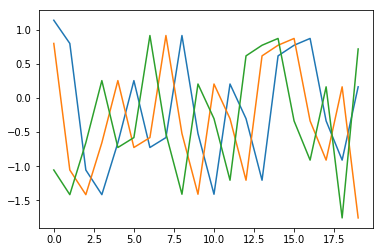

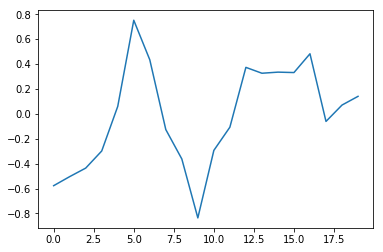

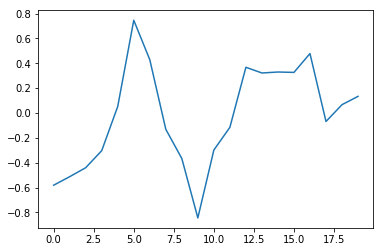

0.999862346762
X (14998, 10, 3) Y (14998, 1) pred (14998, 1)


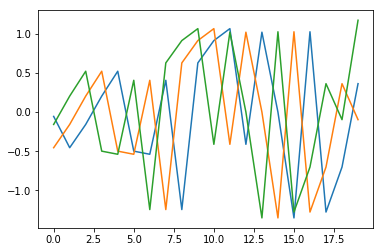

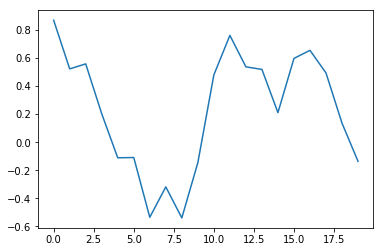

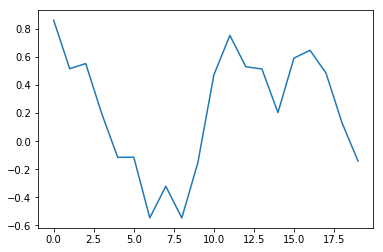

0.999846706194
X (14999, 10, 3) Y (14999, 1) pred (14999, 1)


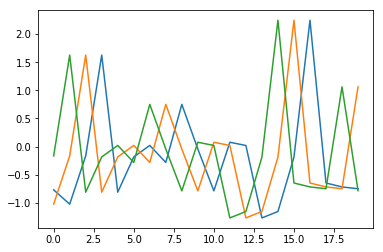

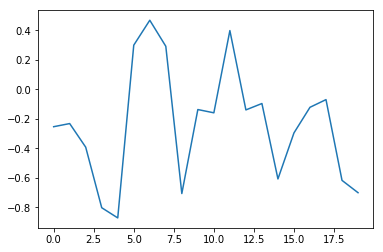

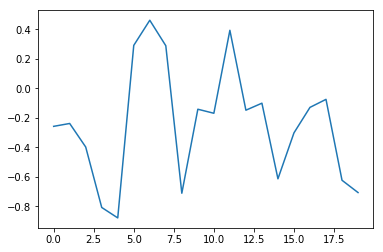

0.99986735997


In [6]:
from matplotlib import pyplot as plt
def myPlot(X):
    plt.plot(X)
    plt.show()

#def R2(X, Y, model):
#    Y_mean = np.mean(Y, axis=0)
#    pred = model.predict(X)
#    res = np.sum(np.square(Y - pred))
#    tot = np.sum(np.square(Y - Y_mean))
#    r2 = 1 - res / tot
#    return r2

def R2(X, Y, model):
    Y_mean = np.mean(Y, axis=0)
    pred = model.predict(X)
    print('X', X.shape, 'Y', Y.shape, 'pred', pred.shape)
    #pred = pred.reshape(Y.shape[0])
    #print('reshaped pred', pred.shape)
    res = np.sum(np.square(Y - pred))
    tot = np.sum(np.square(Y - Y_mean))
    r2 = 1 - res / tot
    myPlot(X[:20,0])
    myPlot(Y[:20])
    myPlot(pred[:20])
    return r2

#model.load_weights(weights_path)
print(R2(X_train, Y_train, model))
print(R2(X_validation, Y_validation, model))
print(R2(X_test, Y_test, model))